In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("./data/train.csv")

In [3]:
df_dummies = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'], drop_first=True)

In [4]:
df_features = df_dummies.drop(['id', 'day', 'month', 'y'], axis=1)

In [5]:
X = df_features.values
y = df_dummies.y.values

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
import xgboost

seed = 123
np.random.seed(seed)

In [7]:
def cross_validation(clf, X, y, n_splits=10, shuffle=False):
    kfold = KFold(n_splits, shuffle=shuffle)
    for train_index, test_index in kfold.split(X):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        clf.fit(X_train, y_train)
        print(clf.score(X_test, y_test))

In [8]:
clf = xgboost.XGBClassifier(n_jobs=4)
cross_validation(clf, X, y, n_splits=5)
clf.feature_importances_

0.906745300405
0.897899004792
0.896056026539
0.900460829493
0.903778801843


array([ 0.10879285,  0.10730253,  0.32488823,  0.04918033,  0.10134128,
        0.01937407,  0.01043219,  0.00298063,  0.00596125,  0.        ,
        0.        ,  0.00447094,  0.        ,  0.02235469,  0.00298063,
        0.        ,  0.        ,  0.01937407,  0.00149031,  0.00298063,
        0.01639344,  0.        ,  0.00596125,  0.05514158,  0.02831595,
        0.00596125,  0.05514158,  0.        ,  0.04918033,  0.        ], dtype=float32)

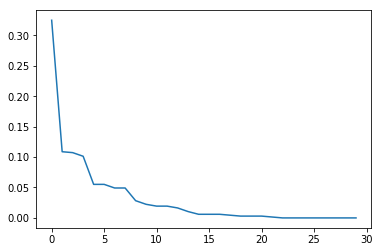

In [9]:
plt.plot(clf.feature_importances_[np.argsort(clf.feature_importances_)[::-1]])

0.905823811279
0.898083302617
0.895503133063
0.901751152074
0.905622119816


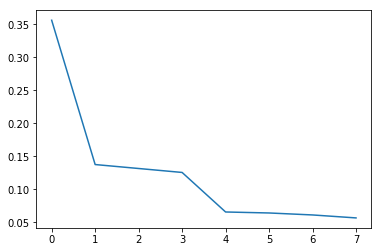

In [10]:
X_subset = X[:, np.argsort(clf.feature_importances_)[::-1][:8]]
subset_clf = xgboost.XGBClassifier(n_jobs=4)
cross_validation(subset_clf, X_subset, y, n_splits=5)
plt.plot(subset_clf.feature_importances_[np.argsort(subset_clf.feature_importances_)[::-1]])

In [18]:
from sklearn.model_selection import StratifiedKFold
from pprint import pprint

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def score(params):
    print('Training with ...')
    pprint(params)
    scores = []
    kfold = KFold(n_splits=10, shuffle=True, random_state=123)
    for train, test in kfold.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        d_train = xgboost.DMatrix(X_train, label=y_train)
        d_test = xgboost.DMatrix(X_test, label=y_test)
        watchlist = [(d_train, 'train'), (d_test, 'eval')]
        model = xgboost.train(params, d_train, num_boost_round=150,evals=watchlist,early_stopping_rounds=10, verbose_eval=False)
        model.predict(d_test)
        score = model.best_score
        scores.append(score)
    avg_score = np.average(scores)
    print('Average Score: {}'.format(avg_score))
    return { 'loss': avg_score, 'status': STATUS_OK }

def optimize(trials):
    space = {
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        
        #Control complexity of model
        "eta" : hp.quniform("eta", 0.2, 0.6, 0.05),
        "max_depth" : hp.choice('max_depth', np.arange(1, 10+1, dtype=int)),
        "min_child_weight" : hp.quniform('min_child_weight', 1, 10, 1),
        'gamma' : hp.quniform('gamma', 0, 1, 0.05),
        
        #Improve noise robustness 
        "subsample" : hp.quniform('subsample', 0.5, 1, 0.05),
        "colsample_bytree" : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        
        'num_class' : 3,
        'silent' : 1}
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)
    print('best parameters: {}'.format(best))

In [19]:
trials = Trials()
optimize(trials)
# score(params)

Training with ...
{'colsample_bytree': 0.8500000000000001,
 'eta': 0.4,
 'eval_metric': 'mlogloss',
 'gamma': 0.75,
 'max_depth': 10,
 'min_child_weight': 5.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.7000000000000001}
Average Score: 0.23494420000000002
Training with ...
{'colsample_bytree': 0.75,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.35000000000000003,
 'max_depth': 10,
 'min_child_weight': 7.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.55}
Average Score: 0.2319349
Training with ...
{'colsample_bytree': 0.55,
 'eta': 0.45,
 'eval_metric': 'mlogloss',
 'gamma': 0.30000000000000004,
 'max_depth': 6,
 'min_child_weight': 6.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 1.0}
Average Score: 0.2275788
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.35000000000000003,
 'eval_metric': 'mlogloss',
 'gamma': 0.8,
 'max_depth': 9,
 'min_child_weight': 3.0,
 'num_class

Average Score: 0.22547630000000002
Training with ...
{'colsample_bytree': 0.75,
 'eta': 0.45,
 'eval_metric': 'mlogloss',
 'gamma': 0.2,
 'max_depth': 3,
 'min_child_weight': 4.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.9}
Average Score: 0.22638409999999998
Training with ...
{'colsample_bytree': 0.9,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.4,
 'max_depth': 4,
 'min_child_weight': 3.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.9500000000000001}
Average Score: 0.2253151
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.35000000000000003,
 'eval_metric': 'mlogloss',
 'gamma': 0.75,
 'max_depth': 8,
 'min_child_weight': 5.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8500000000000001}
Average Score: 0.23025820000000002
Training with ...
{'colsample_bytree': 0.75,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 1.0,
 'max_depth': 1,
 'min_child_weight': 2.0,
 

Average Score: 0.23366779999999995
Training with ...
{'colsample_bytree': 0.9,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.0,
 'max_depth': 2,
 'min_child_weight': 9.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8}
Average Score: 0.22709569999999996
Training with ...
{'colsample_bytree': 0.8500000000000001,
 'eta': 0.6000000000000001,
 'eval_metric': 'mlogloss',
 'gamma': 0.9500000000000001,
 'max_depth': 4,
 'min_child_weight': 10.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.55}
Average Score: 0.22840280000000002
Training with ...
{'colsample_bytree': 0.5,
 'eta': 0.5,
 'eval_metric': 'mlogloss',
 'gamma': 0.75,
 'max_depth': 5,
 'min_child_weight': 8.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.65}
Average Score: 0.22672119999999998
Training with ...
{'colsample_bytree': 0.55,
 'eta': 0.45,
 'eval_metric': 'mlogloss',
 'gamma': 0.15000000000000002,
 'max_depth': 4,


Average Score: 0.23354869999999997
Training with ...
{'colsample_bytree': 0.75,
 'eta': 0.30000000000000004,
 'eval_metric': 'mlogloss',
 'gamma': 0.9,
 'max_depth': 6,
 'min_child_weight': 10.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.9500000000000001}
Average Score: 0.2268191
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.35000000000000003,
 'eval_metric': 'mlogloss',
 'gamma': 0.6000000000000001,
 'max_depth': 4,
 'min_child_weight': 4.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8}
Average Score: 0.22539919999999997
Training with ...
{'colsample_bytree': 0.7000000000000001,
 'eta': 0.55,
 'eval_metric': 'mlogloss',
 'gamma': 1.0,
 'max_depth': 2,
 'min_child_weight': 2.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.7000000000000001}
Average Score: 0.2283485
Training with ...
{'colsample_bytree': 0.9500000000000001,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 

Average Score: 0.2262186
Training with ...
{'colsample_bytree': 0.65,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0.05,
 'max_depth': 5,
 'min_child_weight': 3.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.75}
Average Score: 0.22557860000000002
Training with ...
{'colsample_bytree': 0.75,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 1.0,
 'max_depth': 4,
 'min_child_weight': 9.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8500000000000001}
Average Score: 0.22524469999999996
Training with ...
{'colsample_bytree': 0.9,
 'eta': 0.35000000000000003,
 'eval_metric': 'mlogloss',
 'gamma': 0.75,
 'max_depth': 9,
 'min_child_weight': 1.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.75}
Average Score: 0.23596869999999998
Training with ...
{'colsample_bytree': 0.8500000000000001,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0.8500000000000001,
 'max_depth': 7,
 'min_chil

Average Score: 0.22527709999999995
Training with ...
{'colsample_bytree': 0.8500000000000001,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.15000000000000002,
 'max_depth': 4,
 'min_child_weight': 4.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8}
Average Score: 0.22540700000000005
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0.30000000000000004,
 'max_depth': 4,
 'min_child_weight': 5.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.9}
Average Score: 0.22525889999999998
Training with ...
{'colsample_bytree': 0.8500000000000001,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0.2,
 'max_depth': 2,
 'min_child_weight': 3.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8500000000000001}
Average Score: 0.2277526
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.45,
 'max_depth': 4

Average Score: 0.2252342
Training with ...
{'colsample_bytree': 0.9,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.15000000000000002,
 'max_depth': 2,
 'min_child_weight': 6.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 1.0}
Average Score: 0.22841129999999996
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.35000000000000003,
 'eval_metric': 'mlogloss',
 'gamma': 0.9500000000000001,
 'max_depth': 4,
 'min_child_weight': 10.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8}
Average Score: 0.22569790000000003
Training with ...
{'colsample_bytree': 0.8500000000000001,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.2,
 'max_depth': 5,
 'min_child_weight': 3.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.75}
Average Score: 0.22639740000000003
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0.75,
 'max_depth': 9,
 'min_child

Average Score: 0.228112
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0.9500000000000001,
 'max_depth': 5,
 'min_child_weight': 10.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8}
Average Score: 0.225281
Training with ...
{'colsample_bytree': 0.8500000000000001,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.9,
 'max_depth': 4,
 'min_child_weight': 8.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.9}
Average Score: 0.2251509
Training with ...
{'colsample_bytree': 0.6000000000000001,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 1.0,
 'max_depth': 9,
 'min_child_weight': 6.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8500000000000001}
Average Score: 0.2284612
Training with ...
{'colsample_bytree': 0.9,
 'eta': 0.30000000000000004,
 'eval_metric': 'mlogloss',
 'gamma': 0.7000000000000001,
 'max_depth': 4,
 'min_child_weigh

Average Score: 0.22624069999999996
Training with ...
{'colsample_bytree': 0.75,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.8500000000000001,
 'max_depth': 9,
 'min_child_weight': 8.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.9500000000000001}
Average Score: 0.23000600000000002
Training with ...
{'colsample_bytree': 0.8500000000000001,
 'eta': 0.2,
 'eval_metric': 'mlogloss',
 'gamma': 0.9500000000000001,
 'max_depth': 4,
 'min_child_weight': 6.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.9}
Average Score: 0.22498269999999998
Training with ...
{'colsample_bytree': 0.7000000000000001,
 'eta': 0.4,
 'eval_metric': 'mlogloss',
 'gamma': 0.8,
 'max_depth': 7,
 'min_child_weight': 4.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 1.0}
Average Score: 0.2283076
Training with ...
{'colsample_bytree': 0.6000000000000001,
 'eta': 0.25,
 'eval_metric': 'mlogloss',
 'gamma': 0.9,
 '

In [48]:
from sklearn.model_selection import StratifiedKFold
from pprint import pprint

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def score(params):
    print('Training with ...')
    pprint(params)
    scores = []
    kfold = KFold(n_splits=10, shuffle=True, random_state=123)
    for train, test in kfold.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        clf = xgboost.XGBClassifier(**params)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print(score)
        scores.append(score)
    avg_score = np.average(scores)
    print('Average Score: {}'.format(avg_score))
    return { 'loss': -avg_score, 'status': STATUS_OK }

def optimize(trials):
    space = {
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        
        #Control complexity of model
        "eta" : hp.quniform("eta", 0.2, 0.6, 0.05),
        "max_depth" : hp.choice('max_depth', np.arange(1, 10+1, dtype=int)),
        "min_child_weight" : hp.quniform('min_child_weight', 1, 10, 1),
        'gamma' : hp.quniform('gamma', 0, 1, 0.05),
        
        #Improve noise robustness 
        "subsample" : hp.quniform('subsample', 0.5, 1, 0.05),
        "colsample_bytree" : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        
        'num_class' : 3,
        'silent' : 1}
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)
    print('best parameters: {}'.format(best))

In [49]:
trials = Trials()
optimize(trials)
# score(params)

Training with ...
{'colsample_bytree': 0.9,
 'eta': 0.6000000000000001,
 'eval_metric': 'mlogloss',
 'gamma': 0.75,
 'max_depth': 5,
 'min_child_weight': 2.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.75}
0.89052709178
0.894950239587
0.903796535201
0.9030593439
0.898267600442
0.906376704755
0.910431256911
0.899004791743
0.907079646018
0.908554572271
Average Score: 0.9022047782609027
Training with ...
{'colsample_bytree': 0.55,
 'eta': 0.5,
 'eval_metric': 'mlogloss',
 'gamma': 0.35000000000000003,
 'max_depth': 8,
 'min_child_weight': 2.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.9}
0.890895687431
0.894950239587
0.899741983045
0.903796535201
0.89052709178
0.909325469959
0.905639513454
0.893844452635
0.904867256637
0.905604719764
Average Score: 0.8999192949493698
Training with ...
{'colsample_bytree': 0.9,
 'eta': 0.35000000000000003,
 'eval_metric': 'mlogloss',
 'gamma': 0.30000000000000004,
 'max_depth': 6,
 'm

0.889789900479
0.892370070033
0.900847769996
0.898636196093
0.885735348323
0.900479174346
0.907851087357
0.89015849613
0.896755162242
0.905235988201
Average Score: 0.8967859193199572
Training with ...
{'colsample_bytree': 0.5,
 'eta': 0.45,
 'eval_metric': 'mlogloss',
 'gamma': 0.75,
 'max_depth': 4,
 'min_child_weight': 10.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.65}
0.895318835238
0.893107261334
0.905270917803
0.902690748249
0.891632878732
0.906376704755
0.911905639513
0.896424622189
0.905604719764
0.911873156342
Average Score: 0.9020205483920423
Training with ...
{'colsample_bytree': 0.65,
 'eta': 0.6000000000000001,
 'eval_metric': 'mlogloss',
 'gamma': 0.65,
 'max_depth': 3,
 'min_child_weight': 9.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.65}
0.894950239587
0.894213048286
0.904902322153
0.901216365647
0.891264283081
0.906008109104
0.911905639513
0.901584961297
0.904867256637
0.910766961652
Average Sco

0.902322152599
0.900847769996
0.892370070033
0.906008109104
0.905639513454
0.893107261334
0.903761061947
0.902286135693
Average Score: 0.899366238378092
Training with ...
{'colsample_bytree': 0.8500000000000001,
 'eta': 0.5,
 'eval_metric': 'mlogloss',
 'gamma': 0.8,
 'max_depth': 2,
 'min_child_weight': 10.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.6000000000000001}
0.899373387394
0.893844452635
0.901584961297
0.901216365647
0.892001474383
0.904533726502
0.910431256911
0.899373387394
0.90191740413
0.908554572271
Average Score: 0.9012830988564836
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.55,
 'eval_metric': 'mlogloss',
 'gamma': 0.55,
 'max_depth': 9,
 'min_child_weight': 5.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8}
0.893107261334
0.895318835238
0.899741983045
0.902322152599
0.890895687431
0.904902322153
0.907482491707
0.89015849613
0.902654867257
0.903761061947
Average Score: 0.899034515883862

0.891632878732
0.89679321784
0.902322152599
0.901216365647
0.890895687431
0.906008109104
0.906745300405
0.892370070033
0.901548672566
0.906710914454
Average Score: 0.8996243368812025
Training with ...
{'colsample_bytree': 0.5,
 'eta': 0.5,
 'eval_metric': 'mlogloss',
 'gamma': 0.9500000000000001,
 'max_depth': 3,
 'min_child_weight': 8.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8}
0.897899004792
0.893844452635
0.905639513454
0.901216365647
0.891632878732
0.906745300405
0.90969406561
0.900847769996
0.904498525074
0.912241887906
Average Score: 0.9024259764251006
Training with ...
{'colsample_bytree': 0.6000000000000001,
 'eta': 0.5,
 'eval_metric': 'mlogloss',
 'gamma': 0.30000000000000004,
 'max_depth': 1,
 'min_child_weight': 2.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.8500000000000001}
0.888684113527
0.892001474383
0.900479174346
0.900110578695
0.884998157022
0.901953556948
0.906008109104
0.889421304829
0.8

0.893475856985
0.894213048286
0.905639513454
0.90342793955
0.897899004792
0.908219683008
0.911537043863
0.901953556948
0.908185840708
0.909292035398
Average Score: 0.9033843522991563
Training with ...
{'colsample_bytree': 0.55,
 'eta': 0.4,
 'eval_metric': 'mlogloss',
 'gamma': 0.8,
 'max_depth': 8,
 'min_child_weight': 9.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.5}
0.895687430888
0.897161813491
0.902322152599
0.904902322153
0.895318835238
0.908956874309
0.911537043863
0.896056026539
0.904867256637
0.907448377581
Average Score: 0.9024258133296799
Training with ...
{'colsample_bytree': 0.8,
 'eta': 0.55,
 'eval_metric': 'mlogloss',
 'gamma': 0.9,
 'max_depth': 5,
 'min_child_weight': 8.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.55}
0.897161813491
0.895318835238
0.907113896056
0.903796535201
0.896056026539
0.907851087357
0.912642830815
0.900110578695
0.908185840708
0.909292035398
Average Score: 0.9037529479497

0.896424622189
0.907851087357
0.911168448212
0.901584961297
0.906342182891
0.910029498525
Average Score: 0.9039003454361009
Training with ...
{'colsample_bytree': 0.6000000000000001,
 'eta': 0.35000000000000003,
 'eval_metric': 'mlogloss',
 'gamma': 1.0,
 'max_depth': 4,
 'min_child_weight': 10.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.5}
0.894950239587
0.894581643937
0.907113896056
0.903796535201
0.892370070033
0.906376704755
0.913748617766
0.898267600442
0.907079646018
0.910398230088
Average Score: 0.9028683183883561
Training with ...
{'colsample_bytree': 0.55,
 'eta': 0.4,
 'eval_metric': 'mlogloss',
 'gamma': 0.9,
 'max_depth': 4,
 'min_child_weight': 10.0,
 'num_class': 3,
 'objective': 'multi:softprob',
 'silent': 1,
 'subsample': 0.5}
0.898636196093
0.890895687431
0.906008109104
0.904533726502
0.893107261334
0.908588278658
0.910431256911
0.897530409141
0.905604719764
0.910766961652
Average Score: 0.9026102606591012
Training with ...
{'cols

KeyboardInterrupt: 

In [22]:
best_params = {'colsample_bytree': 0.8, 'eta': 0.2, 'gamma': 0.9, 'max_depth': 3, 'min_child_weight': 4.0, 'subsample': 0.8500000000000001}

d = xgboost.DMatrix(X, label=y)

watchlist = [(d, 'train')]
model = xgboost.train(best_params, d, num_boost_round=150,evals=watchlist,early_stopping_rounds=10, verbose_eval=False)

In [25]:
df_test = pd.read_csv("./data/test.csv")
df_test_dummies = pd.get_dummies(df_test, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'], drop_first=True)
df_test_features = df_test_dummies.drop(['id', 'day', 'month'], axis=1)
X_test = df_test_features.values
predict = model.predict(xgboost.DMatrix(X_test))

In [31]:
df_predicts = pd.DataFrame(np.c_[df_test.id.values.astype(np.int64), predict], columns=['id', 'prediction'])

In [32]:
df_predicts.id  = df_predicts.id.values.astype(np.int64)

In [33]:
df_predicts.to_csv("./data/submit.csv", header=None, index=None)

In [34]:
df_predicts

,id,prediction
0,1,0.618770
1,2,0.595712
2,3,-0.026217
3,4,-0.024960
4,5,0.175662
5,6,0.026513
6,7,-0.006498
7,8,0.008795
8,9,0.064689
9,10,0.166876


In [ ]:
df = pd.read_csv("./data/train.csv")
df_dummies = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'], drop_first=True)

In [ ]:
df_dummies.pdays.where(df.pdays >= 0, 999, inplace=True)

In [ ]:
df_dummies